In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical features

In [2]:
df = pd.read_parquet('./data/cleaner_sample.parquet')
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [3]:
category_columns = [
    'gender',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'paperlessbilling',
    'paymentmethod',
    'contract'
]

## 1. Diff & risk ratio
see the distribution of label `churn` in different groups
1. difference, $\text{diff} = group - global$
	- $>0$ prone to positive
	- $< 0$ prone to negative
2. risk ratio, $\frac{group}{global}$
	- $>1$ prone to positive
	- $< 1$ prone to negative

> we can't interprete the result across groups

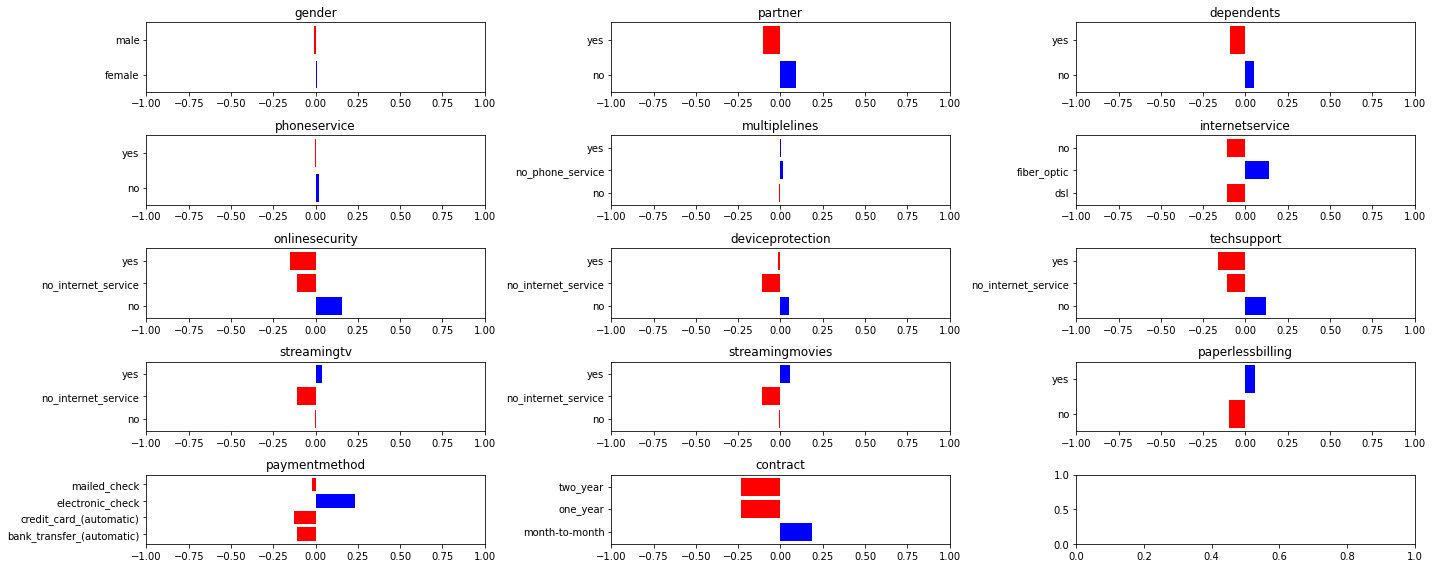

In [4]:
def show_mean_diff(df, col_base, col_others, ncols=3):
    rows = int(np.ceil(len(col_others) / ncols))
    fig, axes = plt.subplots(rows, ncols, figsize=(20,8))
    base_mean = df[col_base].mean()
    for i, col in enumerate(col_others):
        df_group = df.groupby(col).churn.agg(['mean'])
        df_group['diff'] = df_group['mean'] - base_mean
        df_group['risk'] = df_group['mean'] / base_mean
        colors = (df_group['diff'] >= 0).map({
            True: 'blue',
            False: 'red'
        })
        y = df_group.index
        ax = axes[i//ncols][i%ncols]
        ax.barh(y, df_group['diff'], color=colors)
        ax.set_xticks(np.linspace(-1, 1, 9))
        ax.set_title(col)
    fig.tight_layout()
    return fig, axes

show_mean_diff(df, 'churn', category_columns);

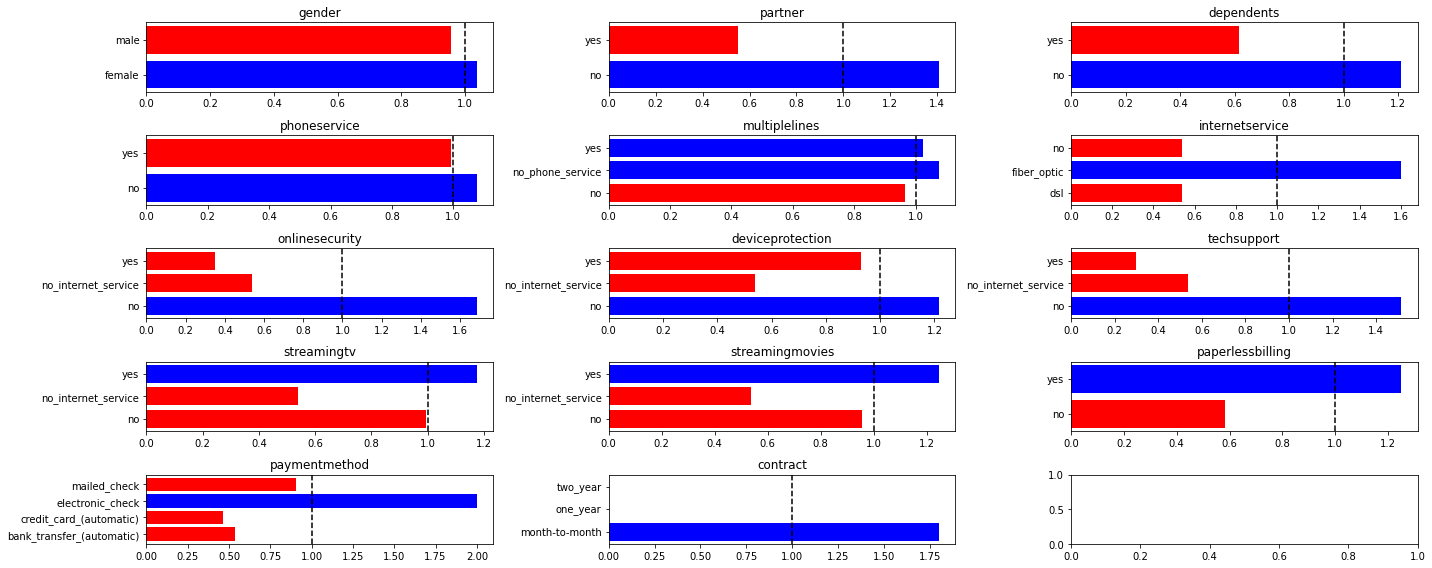

In [5]:
def show_risk_ratio(df, col_base, col_others, ncols=3):
    rows = int(np.ceil(len(category_columns) / ncols))
    fig, axes = plt.subplots(rows, ncols, figsize=(20,8))
    base_mean = df[col_base].mean()
    for i, col in enumerate(col_others):
        df_group = df.groupby(col).churn.agg(['mean'])
        df_group['diff'] = df_group['mean'] - base_mean
        df_group['risk'] = df_group['mean'] / base_mean
        colors = (df_group['risk'] >= 1).map({
            True: 'blue',
            False: 'red'
        })
        y = df_group.index
        ax = axes[i//ncols][i%ncols]
        ax.axvline(x=1.0, c='black', linestyle='--')
        ax.barh(y, df_group['risk'], color=colors)
        ax.set_title(col)
    fig.tight_layout()
    return fig, axes

show_risk_ratio(df, 'churn', category_columns);

## 2. Mutual information

comparing across group

In [6]:
from sklearn.metrics import mutual_info_score

In [7]:
def show_mutual_info(df, col_base, col_others, n=10):
    mi = df[col_others].apply(lambda series: mutual_info_score(series, df[col_base]))
    fig, ax = plt.subplots(sharex=True)
    # visual order and sort order are opposite direction.
    for idx, val in mi.sort_values()[-n:].items():
        ax.barh(idx, val)

    fig.suptitle(f'mutual information w/ {col_base}')
    fig.tight_layout()
    return fig, ax

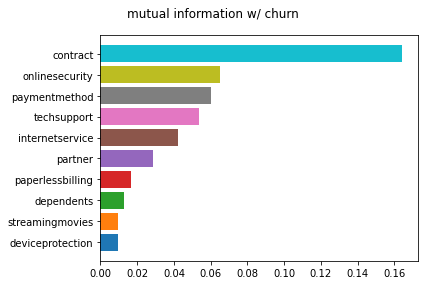

In [8]:
show_mutual_info(df, 'churn', category_columns, 10);

<AxesSubplot:>

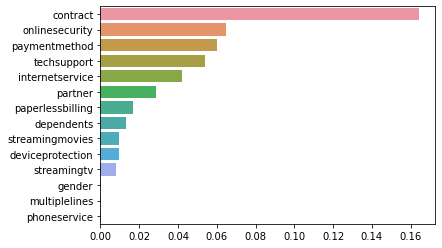

In [9]:
## alternative
mi = df[category_columns].apply(lambda series: mutual_info_score(series, df['churn'])).sort_values(ascending=False)
sns.barplot(x=mi, y=mi.index)

# Numerical features
correlation, `[-1.0, 1.0]`
- around 0, low correlation

strength, the greater the `abs(score)`, the stronger the relationship, also how steep the slope is.
sign
- positive, increase together
- negative, one incresae , one decrease 

## Correlation
range from `[-1.0, 1.0]`, if around 0, low correlation

strength, the greater the `abs(score)`, the stronger the relationship, also how steep the slope is.

sign
- positive, increase together
- negative, one incresae , one decrease 

In [10]:
numerical_cols = [
    'seniorcitizen',
    'tenure',
    'monthlycharges',
    'totalcharges',
    'churn'
]

### matrix

In [11]:
corr = df[numerical_cols].corr()
corr

,seniorcitizen,tenure,monthlycharges,totalcharges,churn
seniorcitizen,1.000000,-0.019794,0.216396,0.099851,-0.017334
tenure,-0.019794,1.000000,0.259969,0.850799,-0.456676
monthlycharges,0.216396,0.259969,1.000000,0.644564,0.130647
totalcharges,0.099851,0.850799,0.644564,1.000000,-0.295177
churn,-0.017334,-0.456676,0.130647,-0.295177,1.000000


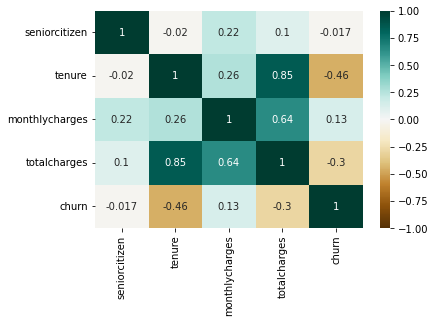

In [12]:
## other divergent cmap
## https://seaborn.pydata.org/tutorial/color_palettes.html
# cmap = sns.color_palette('coolwarm', as_cmap=True)

sns.heatmap(corr, cmap='BrBG', annot=True, vmin=-1.0, vmax=1.0);

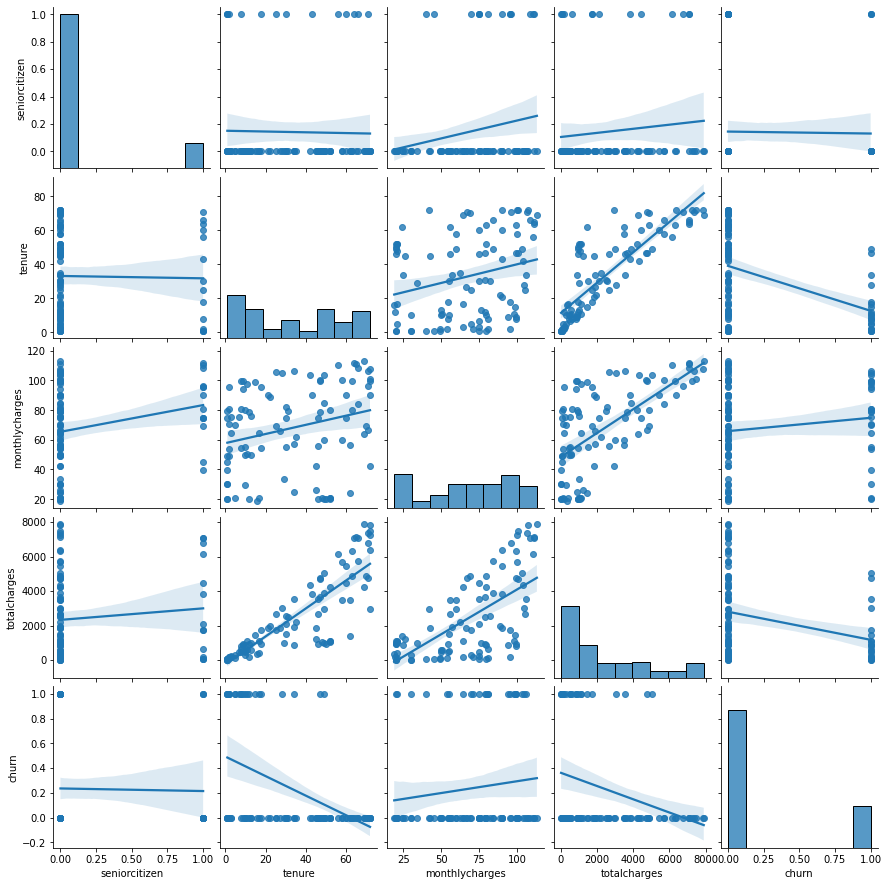

In [13]:
sns.pairplot(df, vars=numerical_cols, kind='reg')

### Corr with one label

In [20]:
corr_w = df[numerical_cols].corrwith(df.churn).sort_values(ascending=False)
corr_w

churn             1.000000
monthlycharges    0.130647
seniorcitizen    -0.017334
totalcharges     -0.295177
tenure           -0.456676
dtype: float64

<AxesSubplot:>

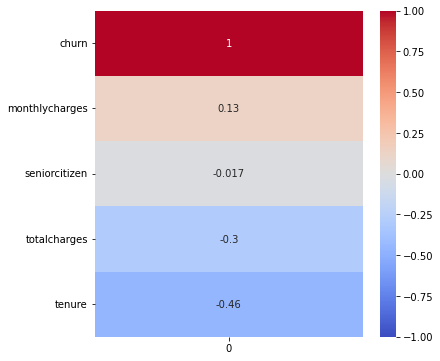

In [21]:
plt.figure(figsize=(6, 6))
cmap = sns.color_palette('coolwarm', as_cmap=True)
sns.heatmap(corr_w.to_frame(), cmap=cmap, annot=True, vmin=-1.0, vmax=1.0)

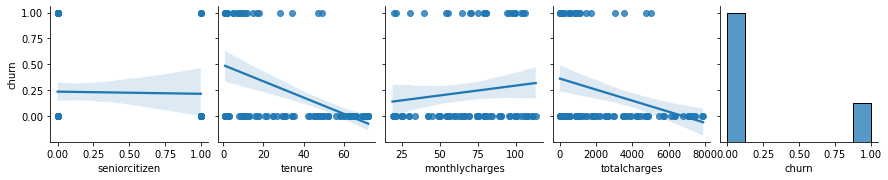

In [22]:
sns.pairplot(df, x_vars=numerical_cols, y_vars=['churn'], kind='reg')

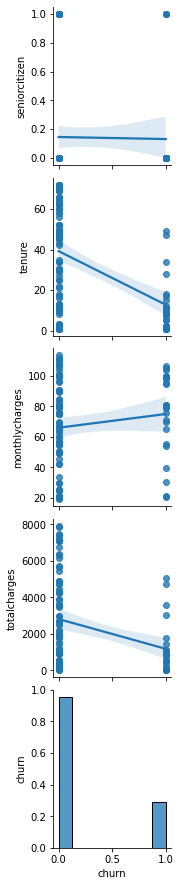

In [23]:
sns.pairplot(df, y_vars=numerical_cols, x_vars=['churn'], kind='reg');